### The aim of this script is to classify defaulting customers based on 17 observations. I made a local database connection, performed data processing, and created 5 classification models. The best model achieved 67.67% accuracy [using Naive Bayes].


### O objetivo é fazer uma classificação de clientes inadimplentes com base em 17 observações. Foi feita a conexão com o banco em que os dados estão alocados. Em seguida o tratamento de dados e a criação de modelos de classificação. O melhor modelo atingiu 67.67 % [Naive bayes].

#### Bibliotecas utilizadas

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from yellowbrick.classifier import ConfusionMatrix
import psycopg2

#### Caso fosse preciso usar LabelEnconder
###### Os dados qualitativos já estavam em formato numérico

In [111]:
# Colunas que precisam de LabelEnconder
#colunasEnconder = [1,2,3,4,6,7,8,11,13]
#encoders = {}
# Gerando LabelEncoders
#for coluna in colunasEnconder:
#    encoders[coluna] = LabelEncoder()
#    previsores[:,coluna] = encoders[coluna].fit_transform(previsores[:,coluna])

#### Conexão e leitura de dados do banco local PostgreSQL

In [112]:
conn = psycopg2.connect(
    host="localhost",
    port="5432",
    database="ProjetoFinal",
    user="postgres",
    password="admin"
)

In [113]:
cursor = conn.cursor()

In [114]:
query = 'SELECT * FROM "CREDITO";'

In [115]:
cursor.execute(query)

In [116]:
results = cursor.fetchall()
dados = pd.DataFrame(results)

In [117]:
query = """SELECT column_name FROM information_schema.columns WHERE table_schema = 'public' AND table_name = 'CREDITO';"""

In [118]:
cursor.execute(query)

In [119]:
results = cursor.fetchall()
rotulos = np.array(results)

In [120]:
cursor.close()
conn.close()

In [121]:
dados.columns = rotulos[:,0]

In [122]:
dados.head()

,IDCREDITO,Duracao,HistoricoCredito,Proposito,Valor,Investimentos,Emprego,TempoParcelamento,EstadoCivil,FiadorTerceiros,ResidenciaDesde,Idade,OutrosFinanciamentos,Habitacao,EmprestimoExistente,Profissao,Dependentes,SocioEmpresa,Estrangeiro,Status
0,2,48,2,1,5951,2,3.0,2,1,3,2.0,22,3,1.0,1,4,1,0,0,0
1,3,12,1,2,2096,2,4.0,2,4,3,3.0,49,3,1.0,1,3,2,0,0,1
2,4,42,2,3,7882,2,4.0,2,4,4,4.0,45,3,2.0,1,4,2,0,0,1
3,5,24,3,4,4870,2,3.0,3,4,3,4.0,53,3,2.0,2,4,2,0,0,0
4,6,36,2,2,9055,1,3.0,2,4,3,4.0,35,3,2.0,1,3,2,1,0,1


#### Início do tratamento de dados - Remoção e NAs e valores incompatíveis, outliers, etc.

In [123]:
dados['HistoricoCredito'].value_counts(dropna=False)

2    526
1    289
3     86
5     48
4     40
0     11
Name: HistoricoCredito, dtype: int64

In [124]:
dados['Proposito'].value_counts(dropna=False)

1     280
4     234
3     181
5     103
6      97
2      50
8      22
7      12
9      12
10      9
Name: Proposito, dtype: int64

In [125]:
dados['Investimentos'].value_counts(dropna=False)

2    603
1    183
5    103
3     63
4     48
Name: Investimentos, dtype: int64

In [126]:
dados['Emprego'].value_counts(dropna=False)

3.0    338
2.0    247
4.0    172
1.0    171
5.0     62
NaN     10
Name: Emprego, dtype: int64

In [127]:
dados['TempoParcelamento'].value_counts(dropna=False)

4    476
2    231
3    157
1    136
Name: TempoParcelamento, dtype: int64

In [128]:
dados['EstadoCivil'].value_counts(dropna=False)

4    548
1    310
3     92
2     50
Name: EstadoCivil, dtype: int64

In [129]:
dados['FiadorTerceiros'].value_counts(dropna=False)

3    908
4     52
2     39
1      1
Name: FiadorTerceiros, dtype: int64

In [130]:
dados['ResidenciaDesde'].value_counts(dropna=False)

4.0    409
2.0    308
3.0    147
1.0    129
NaN      7
Name: ResidenciaDesde, dtype: int64

In [131]:
dados['Idade'].value_counts(dropna=False)

27    51
26    50
23    48
24    44
28    43
25    41
35    40
30    40
36    39
31    38
29    37
32    34
33    33
34    32
37    29
22    27
40    25
38    24
42    22
39    21
46    18
41    17
44    17
43    17
47    17
45    15
20    14
21    14
49    14
48    12
50    12
54    10
52     9
57     9
51     8
55     8
63     8
53     7
61     7
60     6
66     5
64     5
65     5
58     5
74     4
68     3
67     3
56     3
59     3
75     2
19     2
62     2
70     1
Name: Idade, dtype: int64

In [132]:
dados['OutrosFinanciamentos'].value_counts(dropna=False)

3    814
1    139
2     47
Name: OutrosFinanciamentos, dtype: int64

In [133]:
dados['Habitacao'].value_counts(dropna=False)

1.0    709
3.0    175
2.0    107
NaN      9
Name: Habitacao, dtype: int64

In [134]:
dados['EmprestimoExistente'].value_counts(dropna=False)

1    633
2    333
3     28
4      6
Name: EmprestimoExistente, dtype: int64

In [135]:
dados['Profissao'].value_counts(dropna=False)

4      625
3      197
1      147
2       22
999      9
Name: Profissao, dtype: int64

In [136]:
dados['Dependentes'].value_counts(dropna=False)

1    845
2    155
Name: Dependentes, dtype: int64

In [137]:
dados['SocioEmpresa'].value_counts(dropna=False)

0    596
1    404
Name: SocioEmpresa, dtype: int64

In [138]:
dados['Estrangeiro'].value_counts(dropna=False)

0    963
1     37
Name: Estrangeiro, dtype: int64

In [139]:
dados['Status'].value_counts(dropna=False)

1    700
0    300
Name: Status, dtype: int64

#### Tratamento de dados em: Emprego, ResidenciaDesde, Habitacao, Profissao

In [140]:
dados.loc[dados['Emprego'].isna()]

,IDCREDITO,Duracao,HistoricoCredito,Proposito,Valor,Investimentos,Emprego,TempoParcelamento,EstadoCivil,FiadorTerceiros,ResidenciaDesde,Idade,OutrosFinanciamentos,Habitacao,EmprestimoExistente,Profissao,Dependentes,SocioEmpresa,Estrangeiro,Status
64,1,6,0,1,1169,1,NaN,4,4,3,4.0,67,3,1.0,2,4,1,1,0,1
134,78,11,3,1,4771,2,NaN,2,4,3,4.0,51,3,1.0,1,4,1,0,0,1
201,145,21,1,3,2288,2,NaN,4,1,3,4.0,23,3,NaN,1,4,1,1,0,1
983,960,24,2,3,3069,5,NaN,4,4,3,NaN,30,3,2.0,1,4,1,0,0,1
984,56,6,5,4,783,1,NaN,1,4,4,2.0,26,2,1.0,1,3,2,0,0,1
985,270,24,2,1,999,1,NaN,4,4,3,2.0,25,3,1.0,2,4,1,0,0,1
986,896,36,3,5,8947,1,NaN,3,4,3,2.0,31,2,1.0,1,1,2,1,0,1
987,199,24,2,5,2760,1,NaN,4,4,3,4.0,36,1,NaN,1,4,1,1,0,1
992,45,48,1,5,6143,2,NaN,4,1,3,4.0,58,2,2.0,2,999,1,0,0,0
993,95,12,2,4,1318,4,NaN,4,4,3,4.0,54,3,1.0,1,999,1,1,0,1


In [141]:
# Substituicao NaNs de Emprego pela moda
moda = float(dados['Emprego'].mode())

dados['Emprego'].fillna(moda, inplace=True)

In [142]:
dados['Emprego'].value_counts(dropna=False)

3.0    348
2.0    247
4.0    172
1.0    171
5.0     62
Name: Emprego, dtype: int64

In [143]:
# Substituicao NaNs de Residencia pela moda
moda = float(dados['ResidenciaDesde'].mode())

dados['ResidenciaDesde'].fillna(moda, inplace=True)

dados['ResidenciaDesde'].value_counts(dropna=False)

4.0    416
2.0    308
3.0    147
1.0    129
Name: ResidenciaDesde, dtype: int64

In [144]:
# Substituicao NaNs de Habitacao pela moda
moda = float(dados['Habitacao'].mode())

dados['Habitacao'].fillna(moda, inplace=True)

dados['Habitacao'].value_counts(dropna=False)

1.0    718
3.0    175
2.0    107
Name: Habitacao, dtype: int64

In [145]:
# Profissao 999 será setada para 4, pois é um item padrão de profissão
dados['Profissao'].replace(999, 4, inplace=True)
dados['Profissao'].value_counts(dropna=False)

4    634
3    197
1    147
2     22
Name: Profissao, dtype: int64

#### Pré processamento para construcao do modelo

In [146]:
# Separacao de previsores e da classe
previsores = dados.iloc[:,0:17].values
classe = dados.iloc[:,17].values

In [147]:
# Dividindo dados em treino e teste
xTreino, xTeste, yTreino, yTeste = train_test_split(previsores,
                                                    classe,
                                                    test_size=0.3,
                                                    random_state=0)

#### Método: Naive Bayes

In [148]:
# Classificacao com Naive Bayes
naive_bayes = GaussianNB()
naive_bayes.fit(xTreino, yTreino)

GaussianNB()

In [149]:
previsoes = naive_bayes.predict(xTeste)

In [150]:
confusao = confusion_matrix(yTeste, previsoes)
confusao

array([[140,  23],
       [ 74,  63]], dtype=int64)

In [151]:
taxa_acerto = accuracy_score(yTeste, previsoes)
print("Acurácia do modelo: {:.2f}%".format(taxa_acerto * 100))

Acurácia do modelo: 67.67%


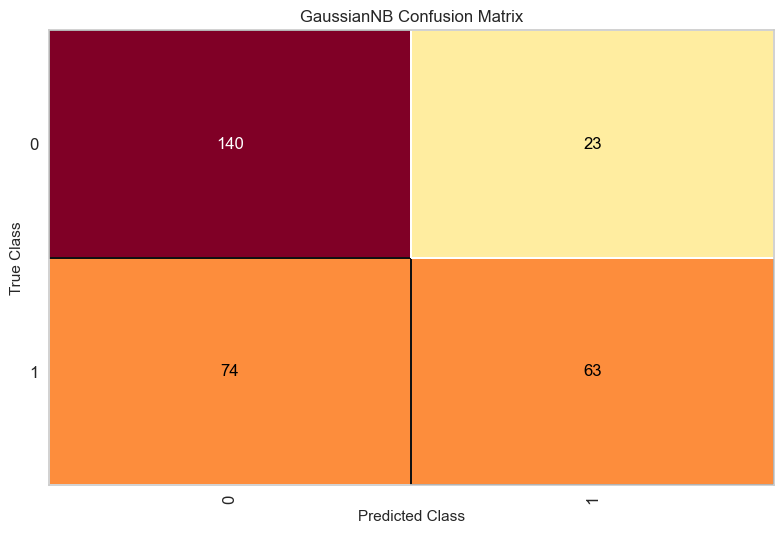

<AxesSubplot:title={'center':'GaussianNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [152]:
v = ConfusionMatrix(GaussianNB())
v.fit(xTreino, yTreino)
v.score(xTeste, yTeste)
v.poof()

#### Método: Regressão Logística

In [153]:
from sklearn.linear_model import LogisticRegression

In [154]:
model = LogisticRegression()
model.fit(xTreino, yTreino)

C:\Users\luanp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [155]:
y_pred = model.predict(xTeste)

In [156]:
taxa_acerto = accuracy_score(yTeste, y_pred)
print("Taxa de acerto: {:.2f}%".format(taxa_acerto * 100))

Taxa de acerto: 67.33%


In [157]:
confusao = confusion_matrix(yTeste, y_pred)
confusao

array([[146,  17],
       [ 81,  56]], dtype=int64)

C:\Users\luanp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


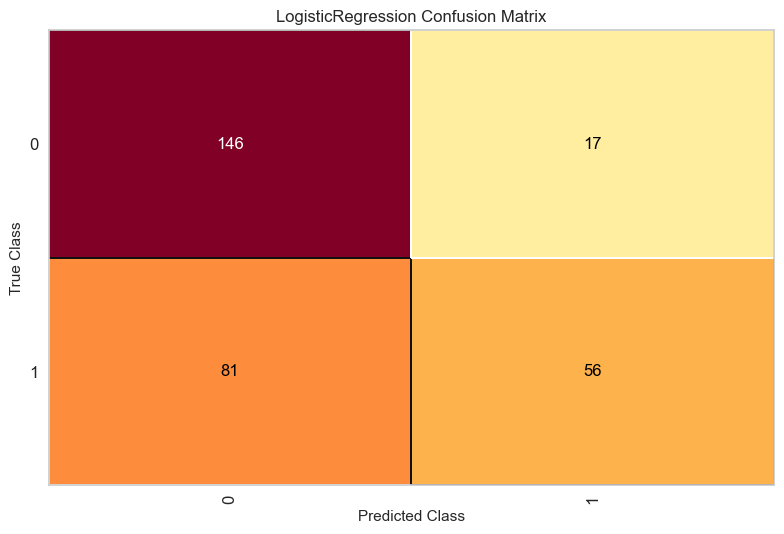

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [158]:
v = ConfusionMatrix(LogisticRegression())
v.fit(xTreino, yTreino)
v.score(xTeste, yTeste)
v.poof()

#### Método: SVM

In [159]:
from sklearn.svm import SVC

In [160]:
modelo = SVC()
modelo.fit(xTreino, yTreino)

SVC()

In [161]:
previsao = modelo.predict(xTeste)

In [162]:
confusao = confusion_matrix(yTeste, previsao)
confusao

array([[145,  18],
       [102,  35]], dtype=int64)

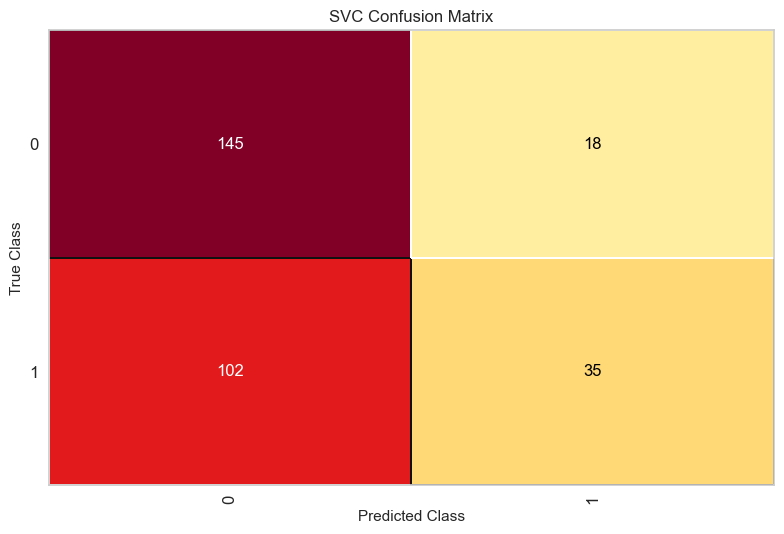

<AxesSubplot:title={'center':'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [163]:
v = ConfusionMatrix(SVC())
v.fit(xTreino, yTreino)
v.score(xTeste, yTeste)
v.poof()

In [164]:
taxa_acerto = accuracy_score(yTeste, previsao)
print("Acurácia do modelo: {:.2f}%".format(taxa_acerto * 100))

Acurácia do modelo: 60.00%


#### Método: Perceptron Multi Camada

In [165]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [166]:
modelo = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(xTreino.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

modelo.fit(xTreino, yTreino, epochs=100, batch_size=32)

Epoch 1/100
22/22 [==============================] - 1s 2ms/step - loss: 38.9472 - accuracy: 0.5257
Epoch 2/100
22/22 [==============================] - 0s 2ms/step - loss: 10.0013 - accuracy: 0.5100
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 6.0935 - accuracy: 0.5271
Epoch 4/100
22/22 [==============================] - 0s 2ms/step - loss: 4.8894 - accuracy: 0.5886
Epoch 5/100
22/22 [==============================] - 0s 2ms/step - loss: 4.5021 - accuracy: 0.5543
Epoch 6/100
22/22 [==============================] - 0s 2ms/step - loss: 2.2763 - accuracy: 0.5400
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 2.5605 - accuracy: 0.5900
Epoch 8/100
22/22 [==============================] - 0s 2ms/step - loss: 2.0306 - accuracy: 0.5643
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 2.2661 - accuracy: 0.5643
Epoch 10/100
22/22 [==============================] - 0s 2ms/step - loss: 1.8920 - accuracy: 0.5714
Epoch 1

In [167]:
perda, taxa_acerto = modelo.evaluate(xTeste, yTeste)
print(f"Taxa de acerto: {100*taxa_acerto:.2f}" " %")

10/10 [==============================] - 0s 2ms/step - loss: 2.1651 - accuracy: 0.5733
Taxa de acerto: 57.33 %


In [168]:
predicao = modelo.predict(xTeste)
predicao = np.round(predicao).astype(int)

10/10 [==============================] - 0s 2ms/step


In [169]:
conf_matrix = confusion_matrix(yTeste, predicao)
print("Matriz de Confusão:")
print(conf_matrix)

Matriz de Confusão:
[[ 53 110]
 [ 18 119]]


#### Método: PCA [2 componentes principais] + Perceptron Multi Camada

In [170]:
# Padronizacao de dados média zero e std 1
norm = StandardScaler()
xNorm = scaler.fit_transform(previsores)

In [171]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(xNorm)

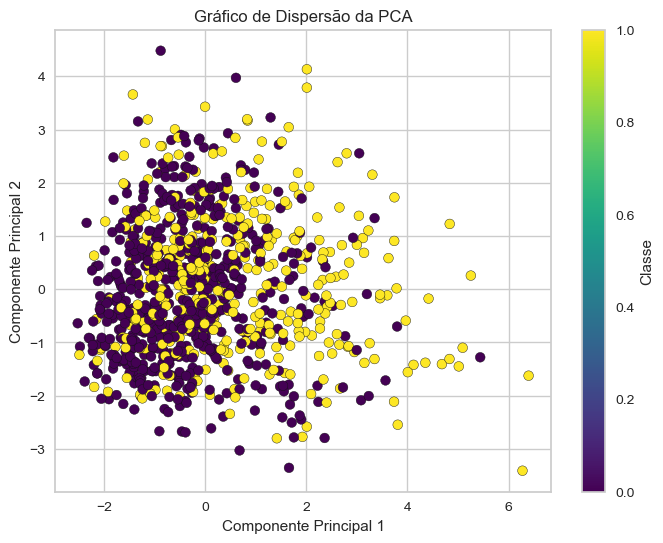

In [172]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=classe, cmap='viridis', edgecolor='k')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Gráfico de Dispersão da PCA')
plt.colorbar(label='Classe')
plt.show()

In [173]:
variance_explained = pca.explained_variance_ratio_
print("Percentual de variância explicada por cada componente principal:")
print(variance_explained)

Percentual de variância explicada por cada componente principal:
[0.11778847 0.09586942 0.07867367 0.07500748 0.06814622 0.0638725
 0.06123794 0.0586681  0.05722509 0.05585636]


In [174]:
# Dividindo dados em treino e teste, novamente, agora informacoes da PCA
xTreino, xTeste, yTreino, yTeste = train_test_split(X_pca,
                                                    classe,
                                                    test_size=0.3,
                                                    random_state=0)

In [175]:
# Rede neural perceptron multicamada
modelo = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(xTreino.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [176]:
modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [177]:
modelo.fit(xTreino, yTreino, epochs=100, batch_size=32)

Epoch 1/100
22/22 [==============================] - 1s 2ms/step - loss: 0.6381 - accuracy: 0.6557
Epoch 2/100
22/22 [==============================] - 0s 2ms/step - loss: 0.6063 - accuracy: 0.6743
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 0.5931 - accuracy: 0.6914
Epoch 4/100
22/22 [==============================] - 0s 2ms/step - loss: 0.5829 - accuracy: 0.7029
Epoch 5/100
22/22 [==============================] - 0s 2ms/step - loss: 0.5756 - accuracy: 0.7043
Epoch 6/100
22/22 [==============================] - 0s 2ms/step - loss: 0.5705 - accuracy: 0.7129
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: 0.5643 - accuracy: 0.7129
Epoch 8/100
22/22 [==============================] - 0s 2ms/step - loss: 0.5588 - accuracy: 0.7129
Epoch 9/100
22/22 [==============================] - 0s 2ms/step - loss: 0.5532 - accuracy: 0.7186
Epoch 10/100
22/22 [==============================] - 0s 2ms/step - loss: 0.5493 - accuracy: 0.7286
Epoch 11/

In [180]:
predicao = modelo.predict(xTeste)
predicao = np.round(predicao).astype(int)

10/10 [==============================] - 0s 2ms/step


In [181]:
conf_matrix = confusion_matrix(yTeste, predicao)
print("Matriz de Confusão:")
print(conf_matrix)

Matriz de Confusão:
[[119  44]
 [ 64  73]]


In [182]:
perda, taxa_acerto = modelo.evaluate(xTeste, yTeste)
print(f"Taxa de acerto: {100*taxa_acerto:.2f}" " %")

10/10 [==============================] - 0s 2ms/step - loss: 0.8478 - accuracy: 0.6400
Taxa de acerto: 64.00 %
